In [1]:
import os

import torch
import torch.nn as nn
from torch.autograd import Variable, grad
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import torch.nn as nn
from PIL import Image
import numpy as np
import random
from tqdm import tqdm

import sys

import pickle
import argparse

import random, string


machine_path = os.getcwd()
user_root_dir = '/'.join(machine_path.split('/')[:-2])
sys.path.insert(0,'%s/redner/'%user_root_dir)
import pyredner



In [2]:
data_folder = '%s/differentiable_graphics_ml/data/train_v7_shapenet/'%user_root_dir

print('PyRedner location: %s'%pyredner.__file__)

DATASET_NAME = 'train_v7_shape_id'
SHAPENET_DIR = '%s/ShapeNetCore.v2'%user_root_dir

dataset_path = "%s/differentiable_graphics_ml/data/%s"%(user_root_dir, DATASET_NAME)

def create_folder(folder_path):
    if not os.path.isdir(folder_path):
        print('Making new directory: %s'%folder_path)
        os.mkdir(folder_path)
create_folder(dataset_path)

PyRedner location: /net/storage001.ib.cluster/om2/user/smadan/redner/pyredner/__init__.py


In [3]:
def render_shapenet_shape_id(info_dict, key):
    all_light_positions, light_intensities, light_sizes, light_look_ats,\
                   camera_position, cam_look_at, fov, cam_up = info_dict[key]
    category, instance, random_key = key.split('_')
    
    obj_path = '%s/ShapeNetCore.v2/%s/%s/models/model_normalized.obj'%(user_root_dir, category, instance)
    obj_model_all = pyredner.load_obj(obj_path, return_objects=True)
    obj_model = [i for i in obj_model_all if len(i.vertices)>0]

    m = pyredner.Material(diffuse_reflectance = torch.tensor([1.0, 1.0, 1.0], device='cuda:0'), \
                          two_sided = True)

    for part in obj_model:
        part.material = m

    scene_cam = pyredner.automatic_camera_placement(obj_model, resolution = (224, 224))
    scene_cam.position = camera_position
    scene_cam.look_at = cam_look_at
    scene_cam.fov = fov
    scene_cam.up = cam_up

    scene_lights = []
    
    num_lights = len(all_light_positions)
    
    for i in range(num_lights):
        light_pos = all_light_positions[i]
        light_look_at = light_look_ats[i]
        light_intensity = light_intensities[i]
        light_size = light_sizes[i]
        
        scene_light = pyredner.generate_quad_light(position = light_pos,
                                         look_at = light_look_at,
                                         size = light_size,
                                         intensity = light_intensity,
                                         directly_visible = False)
        
        scene_lights.append(scene_light)
    
    all_objects = obj_model + scene_lights
    scene = pyredner.Scene(objects = all_objects, camera = scene_cam)
    rendered_channels = [pyredner.channels.shape_id]

    img = pyredner.render_generic(scene,channels = rendered_channels)
    shape_id_arr_ = np.array(img.detach().cpu())[:,:,0]
    total_objects = np.max(shape_id_arr_)
    non_light_objects = total_objects - num_lights
    shape_id_arr = np.logical_and(shape_id_arr_ > 0, shape_id_arr_ <= non_light_objects)
    
    return shape_id_arr

In [4]:
for category in os.listdir(data_folder):
    category_folder = "%s/%s"%(data_folder, category)
    category_randomized_files = "%s/randomized_info_%s.p"%(category_folder, category)
    with open(category_randomized_files,'rb') as F:
        category_files_info = pickle.load(F)
    break
count = 0

In [8]:
# category_files_info['02691156_67da7044f5bee4f65c6d168c6e7f59dc_U2Mfy2GC2HI04anf']

In [9]:
test_key = '02691156_67da7044f5bee4f65c6d168c6e7f59dc_U2Mfy2GC2HI04anf'

In [11]:
category, instance, ID = test_key.split('_')

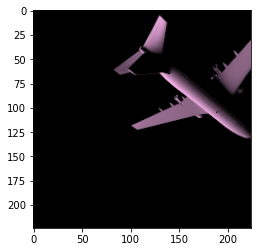

Scene construction, time: 0.64143 s
Forward pass, time: 0.07613 s


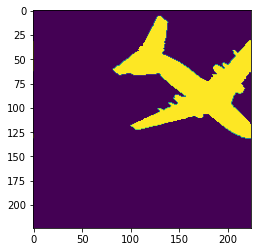

In [19]:
for key in category_files_info.keys():
    if count == 1000:
        category, instance, ID = key.split('_')
        plt.imshow(Image.open('/net/coxfs01/srv/export/coxfs01/pfister_lab2/share_root/Lab/spandan/differentiable_graphics_ml/data/train_v7_shapenet/%s/images/%s.png'%(category, key)))
        plt.show()

        shape_id_arr = render_shapenet_shape_id(category_files_info, key)
        plt.imshow(shape_id_arr)
        plt.show()
        break
    count += 1

'/net/coxfs01/srv/export/coxfs01/pfister_lab2/share_root/Lab/spandan'

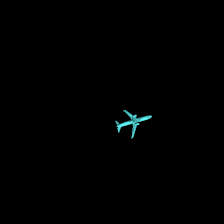

In [35]:
Image.open('%s/differentiable_graphics_ml/data/train_v7_shapenet/02691156/images/02691156_67da7044f5bee4f65c6d168c6e7f59dc_SikARvOYesovag0j.png'%user_root_dir)

In [36]:
a = np.load('%s/differentiable_graphics_ml/data/train_v7_shape_id/02691156/images/02691156_67da7044f5bee4f65c6d168c6e7f59dc_SikARvOYesovag0j.npy'%user_root_dir)

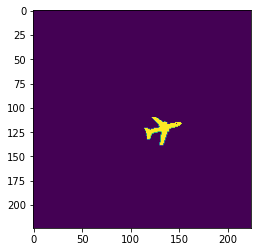

In [37]:
plt.imshow(a)

In [ ]:
# with open(model_files_pickle_path, 'rb') as F:
#     model_files = pickle.load(F)


# RANDOMIZED_INFORMATION_CATEGORY = {}
# total = 0
# category = CATEGORY
# category_dir = "%s/%s"%(SHAPENET_DIR, category)
# category_path = "%s/%s"%(dataset_path, category)
# create_folder(category_path)
# images_folder = "%s/images"%category_path
# create_folder(images_folder)
# instance_model_files = model_files[category]
# for model_file in instance_model_files:
#     model_file = model_file.replace('/om5/user/smadan',user_root_dir)
#     instance = model_file.split('/')[-3]
#     for repeat in range(NUM_REPEATS):
#         rendered_im, im_name, random_info = render_shapenet_obj(model_file)
#         RANDOMIZED_INFORMATION_CATEGORY[im_name] = random_info
#         image_path = "%s/%s.png"%(images_folder, im_name)
#         rendered_im.save(image_path)
#         if total % 10 == 0:
#             with open('%s/randomized_info_%s.p'%(category_path, category),'wb') as F:
#                 pickle.dump(RANDOMIZED_INFORMATION_CATEGORY, F)
#         total += 1